In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=10,6

from pandas import set_option
#set_option('precision',5)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
dataset = pd.read_csv('USCarrier_Traffic_20200602120518.csv',index_col='Period',parse_dates=True,infer_datetime_format=True)

In [3]:
dataset.head()

,Total
Period,
2000-01-01,49045412
2000-02-01,49306303
2000-03-01,60443541
2000-04-01,58286680
2000-05-01,60533783


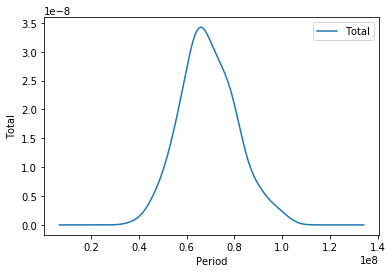

In [4]:
dataset.plot(kind='kde')
plt.xlabel("Period")
plt.ylabel("Total")
plt.show()

Here we conclude that data have a small trend in it and Also data is seasonal.
Additive in nature.

Below we are creating a method to check the Stationarity of the data.

In [5]:
from statsmodels.tsa.stattools import adfuller

def CheckStationary(timeSeries):
    rolMean = timeSeries.rolling(window = 12).mean()
    rolStd = timeSeries.rolling(window = 12).std()

    plt.subplot(111)
    plt.plot(timeSeries, label = 'Original Dataset')
    plt.plot(rolMean, label = 'Rolling Mean')
    plt.plot(rolStd, label = 'Rolling Std')
    plt.xlabel('Period')
    plt.ylabel('Total')
    plt.show()
    
    df = adfuller(timeSeries,autolag='AIC')
    
    dfoutput = pd.Series(df[:4],index=['Test Statistic','P-value','No of Lags','No of Obs'])
    for key,value in df[4].items():
        dfoutput['Crtical value at %s'%key]=value
    print(dfoutput)

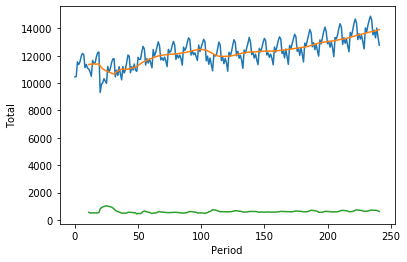

Test Statistic          -0.03278
P-value                  0.95574
No of Lags              13.00000
No of Obs              228.00000
Crtical value at 1%     -3.45936
Crtical value at 5%     -2.87430
Crtical value at 10%    -2.57357
dtype: float64


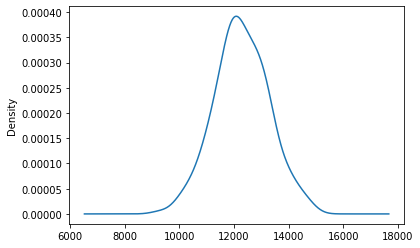

In [6]:
# to make data stationary boxcox is used as one of the tranformamtion
from scipy.stats import boxcox
_, lamb = boxcox(dataset.Total)
lamb
df = pd.DataFrame()
df['boxcox'] = boxcox(dataset.Total,lmbda = lamb)

CheckStationary(df.boxcox)

boxdata = df.boxcox - df.boxcox.shift()
#CheckStationary(boxdata.dropna())
df['boxcox'].plot(kind='kde')

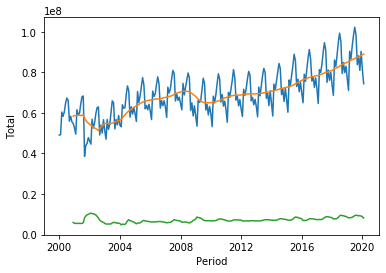

Test Statistic           0.22322
P-value                  0.97353
No of Lags              13.00000
No of Obs              228.00000
Crtical value at 1%     -3.45936
Crtical value at 5%     -2.87430
Crtical value at 10%    -2.57357
dtype: float64


In [7]:
# checking the stationarity of the data.
CheckStationary(dataset)

Using above info we can conclude that our data is not stationary.

I.e. data doesn't have constant mean and std.

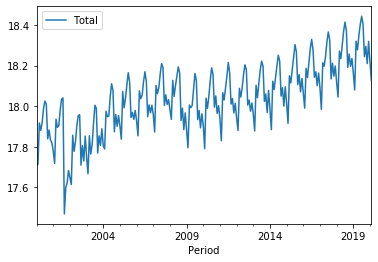

In [8]:
# here we are tranforming the data using log to check stationarity of the data.
datasetLogdata = np.log(dataset)
datasetLogdata.plot()

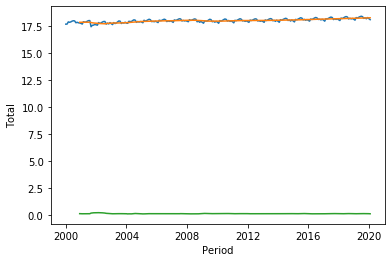

Test Statistic          -0.25552
P-value                  0.93157
No of Lags              13.00000
No of Obs              228.00000
Crtical value at 1%     -3.45936
Crtical value at 5%     -2.87430
Crtical value at 10%    -2.57357
dtype: float64


In [9]:
CheckStationary(datasetLogdata)

# here we can conlude that data have constant mean and constant variance

# for time being we can conclude that our d parameter will be 0 in ARIMA model.

#### using above graph we can conclude that our data is stastionary. but we can also see that p-value is greater and test statistics is also larger than the critical values.

In [10]:
datasetLogdataShift = datasetLogdata - datasetLogdata.shift(1)
datasetLogdataShift.dropna(inplace = True)
datasetLogdataShift

,Total
Period,
2000-02-01,0.00531
2000-03-01,0.20366
2000-04-01,-0.03634
2000-05-01,0.03783
2000-06-01,0.06970
...,...
2019-10-01,0.05108
2019-11-01,-0.08514
2019-12-01,0.10956


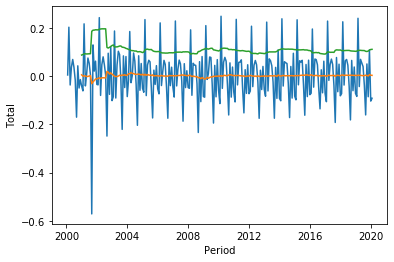

Test Statistic          -4.40448
P-value                  0.00029
No of Lags              12.00000
No of Obs              228.00000
Crtical value at 1%     -3.45936
Crtical value at 5%     -2.87430
Crtical value at 10%    -2.57357
dtype: float64


In [11]:
# now checling the stationary of the log shift data
CheckStationary(datasetLogdataShift)

### Here we can see that p-value is relatively small. And also we have test stastics less than critical values.
##### Also we can see that data have constant mean and variance.

### Now we will check the components of the time series

##### The additive additive model is  useful when the seasonal variation is relatively constant over time

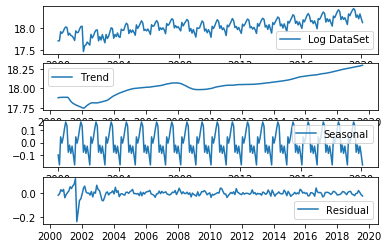

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(datasetLogdata,model='additive')

seasonal = decomposition.seasonal
residual = decomposition.resid
trend = decomposition.trend

plt.subplot(411)
plt.plot(datasetLogdata,label='Log DataSet')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual,label='Residual')
plt.legend(loc = 'best')

plt.show()

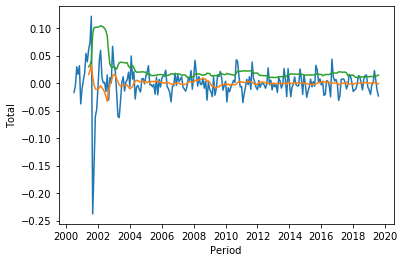

Test Statistic          -6.43510
P-value                  0.00000
No of Lags              15.00000
No of Obs              214.00000
Crtical value at 1%     -3.46128
Crtical value at 5%     -2.87514
Crtical value at 10%    -2.57402
dtype: float64


In [13]:
# check the stationary of the residual
CheckStationary(residual.dropna())

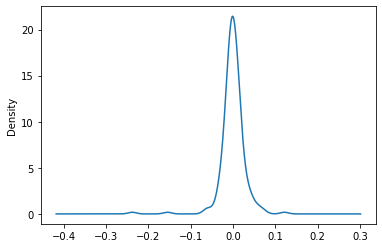

In [14]:
residual.plot(kind='kde')

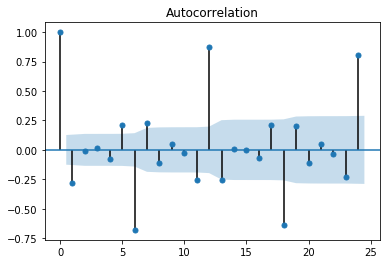

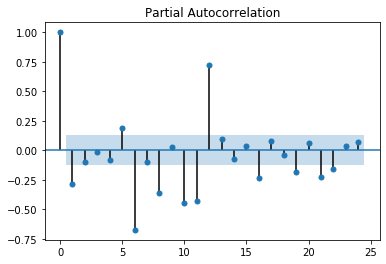

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(datasetLogdataShift, ax=plt.gca())
plt.show()
plot_pacf(datasetLogdataShift, ax=plt.gca()) 
plt.show()

### Now fitting the AARIMA model to the data

In [16]:
import statsmodels.api as sm

In [17]:
model = sm.tsa.statespace.SARIMAX(datasetLogdata,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12))

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [18]:
result = model.fit()

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  242
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 453.538
Date:                            Thu, 11 Jun 2020   AIC                           -897.077
Time:                                    01:00:56   BIC                           -879.908
Sample:                                01-01-2000   HQIC                          -890.151
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2274      0.157      1.448      0.148      -0.080       0.535
ma.L1         -0.5496      0.135     -4.086      0.000      -0.813      -0.286
ar.S.L12      -0.1367      0.035     -3.887      0.000      -0.206      -0.068
ma.S.L12      -0.6979      0.056    -12.548      0.000      -0.807      -0.589
sigma2         0.0011   4.83e-05     22.041      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       34.20   Jarque-Bera (JB):              9813.64
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
from pmdarima import auto_arima

In [21]:
modelN = auto_arima(datasetLogdata, start_p=1, start_q=1,max_p=3, max_q=3, m=12,
                           start_P=1,start_Q=1,max_P=2,max_Q=3,
                           seasonal=True,information_criterion='aic',alpha=0.05,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True
                          )
modelN.fit(datasetLogdata)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=-895.207, BIC=-874.605, Time=3.650 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=-776.166, BIC=-769.299, Time=0.328 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=-869.094, BIC=-855.359, Time=3.145 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=-895.823, BIC=-882.088, Time=1.690 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=-778.165, BIC=-774.731, Time=0.074 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=-791.289, BIC=-780.988, Time=0.665 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=-896.144, BIC=-878.975, Time=2.838 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=-870.994, BIC=-857.260, Time=2.068 seconds
Fit ARIMA(0,1,1)x(2,1,1,12) [intercept=True]; AIC=-894.264, BIC=-873.661, Time=6.355 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=-893.622, BIC=-873.020, Time=9.175 seconds
Fit ARIMA(0,1,1)x(0,1,2,12

ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 2, 12), suppress_warnings=True)

In [22]:
modelN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  242
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 453.178
Date:                                 Thu, 11 Jun 2020   AIC                           -896.356
Time:                                         01:02:35   BIC                           -879.187
Sample:                                              0   HQIC                          -889.430
                                                 - 242                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.001      0.181      0.856      -0.001       0.002
ma.L1         -0.3407      0.061     -5.617      0.000      -0.460      -0.222
ma.S.L12      -0.8495      0.041    -20.933      0.000      -0.929      -0.770
ma.S.L24       0.1310      0.032      4.145      0.000       0.069       0.193
sigma2         0.0011   4.77e-05     22.402      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       34.11   Jarque-Bera (JB):              8802.98
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
finalModel = sm.tsa.statespace.SARIMAX(datasetLogdata,order=(0, 1, 1), seasonal_order=(0, 1, 2, 12), suppress_warnings=True)
finalResult = finalModel.fit()

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [24]:
forecast = finalResult.predict(start=241,end =260,dynamic=False)

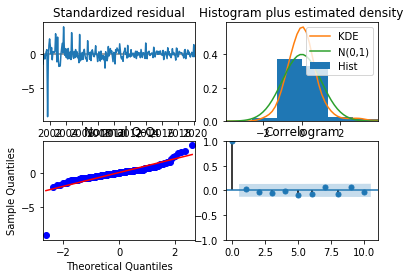

In [25]:
finalResult.plot_diagnostics()
plt.show()

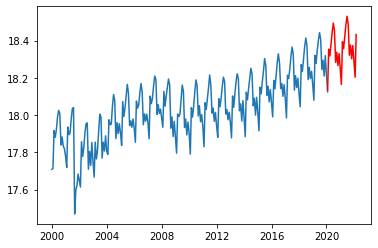

In [26]:
pred = finalResult.get_prediction(start=pd.to_datetime('2020-02-01'), end=pd.to_datetime('2022-03-01'), dynamic=False)
pred_ci = pred.conf_int()
plt.plot(datasetLogdata)
plt.plot(pred.predicted_mean,color = 'red')
#plt.plot(pred_ci['lower Total'],color = 'green')
#plt.plot(pred_ci['upper Total'],color = 'green')

In [27]:
# splitting the data in test and train set

train = datasetLogdata[:round(len(datasetLogdata)*0.7)]
test = datasetLogdata[round(len(datasetLogdata)*0.7):]

In [28]:
# fitting a model to train data
finalModel = sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1), seasonal_order=(0, 1, 2, 12), suppress_warnings=True)
finalResult = finalModel.fit()

C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\DELL\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MSE on test:  0.005847129090856968
RMSE on test:  0.07646652268056242
RSS: 0.4268


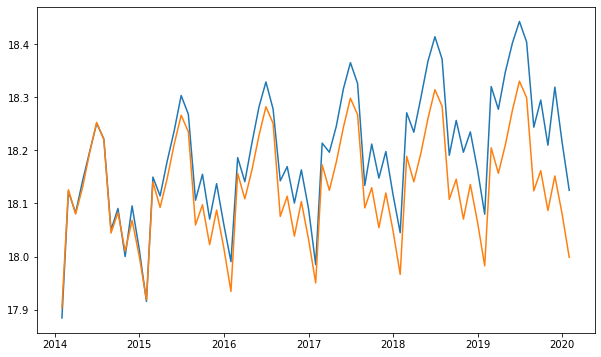

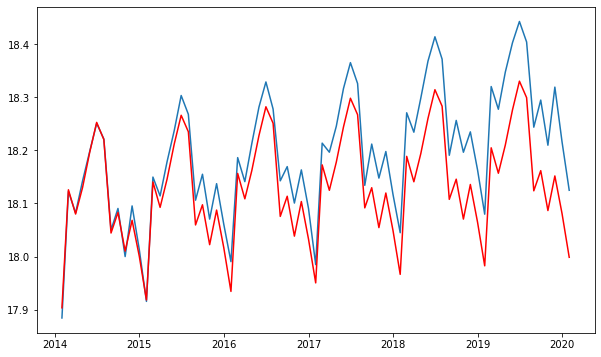

In [44]:
# predicting fot test values
predtest = finalResult.predict(start=test.index[0],end =test.index[len(test)-1])

# calculate MSE on test data
from sklearn.metrics import mean_squared_error
print("MSE on test: ",mean_squared_error(test,predtest))
# calculating RMSE on test data
print("RMSE on test: ",np.sqrt(mean_squared_error(test,predtest)))

print('RSS: %.4f'%sum((predtest - test.Total )**2))

# method 1
predicted = finalResult.predict(start=test.index[0], end = test.index[len(test)-1])
plt.plot(test)
plt.plot(predtest)
plt.show()

# method 2
predtest = finalResult.get_prediction(start=test.index[0], end=test.index[len(test)-1], dynamic=False)
pred_ci_test = predtest.conf_int()
plt.plot(test)
plt.plot(predtest.predicted_mean,color = 'red')

MSE on train:  2.3259963506151022
RMSE on train:  1.5251217494400577
RSS: 393.0934


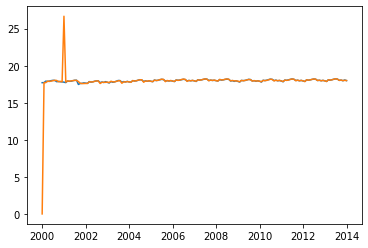

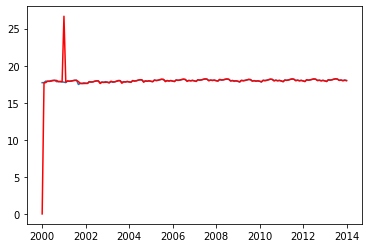

In [30]:
# predicting fot test values
predtrain = finalResult.predict(start=train.index[0],end =train.index[len(train)-1])

# calculate MSE on test data
from sklearn.metrics import mean_squared_error
print("MSE on train: ",mean_squared_error(train,predtrain))
# calculating RMSE on test data
print("RMSE on train: ",np.sqrt(mean_squared_error(train,predtrain)))

print('RSS: %.4f'%sum((finalResult.fittedvalues - train.Total )**2))

# method 1
plt.plot(train)
plt.plot(predtrain)
plt.show()

# method 2
pred_train = finalResult.get_prediction(start=train.index[0], end=train.index[len(train)-1], dynamic=False)
pred_ci_train = pred_train.conf_int()
plt.plot(train)
plt.plot(pred_train.predicted_mean,color = 'red')

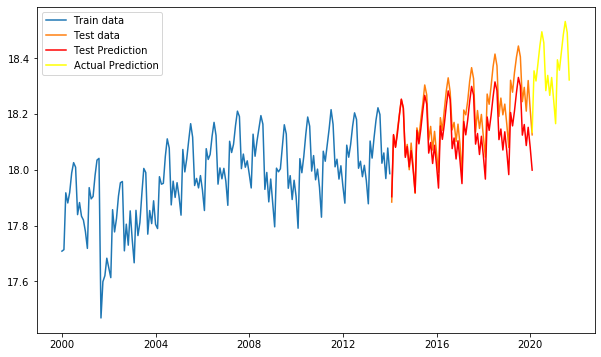

In [34]:
plt.plot(train,label='Train data')
plt.plot(test,label='Test data')
plt.plot(predtest.predicted_mean,color = 'red',label = 'Test Prediction')
plt.plot(forecast,color = 'yellow',label='Actual Prediction')
plt.legend(loc='best')
plt.show()

### Coverting log values into actual values i.e. Taking Anti-Log

In [50]:
dw = pd.DataFrame(np.exp(predicted),columns = ['Pred'])

In [52]:
dw['Actcual'] = np.exp(test)

In [53]:
dw

,Pred,Actcual
2014-02-01,59606926.02549,58474895.00000
2014-03-01,74464726.97225,74237172.00000
2014-04-01,71136971.36936,71278692.00000
2014-05-01,74771059.95830,75712694.00000
2014-06-01,79927525.88143,80063355.00000
...,...,...
2019-10-01,77200039.22222,88190827.00000
2019-11-01,71605579.41457,80993251.00000
2019-12-01,76433597.93187,90371201.00000
2020-01-01,71201633.73797,81511977.00000
